In [1]:
import sys
import json
import os
import numpy as np
sys.path.append(os.environ["CODE_REPOSITORY"])
from code_repository.hotones.thetools import *
import matplotlib.pyplot as plt
from snudda.utils.load import SnuddaLoad

In [2]:
external = os.path.join("/media","jofrony","2TB", "dardel","current_bgd2","population_unit", "surround_inhibition", "supercomputer", "networks")

In [3]:
cell_ids = json.load(open(os.path.join("..", "..","..","..","networks", "pdc_network_2022-08-31", "cell_ids_postsynaptic_dardel.json")))

In [4]:
folder = "dendrite"

In [5]:
parameters = {"start": 0.5, "end": 2.5}

In [6]:
e = Experiments()
e.add_experiment(name="p1",
                 color="black",
                 label="2500 ms stimulation",
                 network="network-synapses.hdf5",
                 path=os.path.join(external, "pdc_network_2022-08-31"),
                 output="network_output_network-synapses_cell_ids_current_injection_dardel_2022-09-21-13-53-04_p1.hdf5")



   

In [7]:
sl = LoadSimulations(experiments=e)
sl.load_network_file(load_synapses=False)

Loading /media/jofrony/2TB/dardel/current_bgd2/population_unit/surround_inhibition/supercomputer/networks/pdc_network_2022-08-31/simulation/network_output_network-synapses_cell_ids_current_injection_dardel_2022-09-21-13-53-04_p1.hdf5
Loading 40000 neurons with 35040256 synapses and 2531 gap junctions


In [8]:
%%time
neuron_type="post_synaptic"
specific_trace_ids = {k: cell_ids[neuron_type][::10] for k in e.experiments}
dv = dendrite_voltage(data_obj=sl, neuron_type=neuron_type,dt_step=0.5, specific_trace_ids=specific_trace_ids, interval=[0,3])

  post_synaptic and 1651 traces
CPU times: user 1min 21s, sys: 6.54 s, total: 1min 28s
Wall time: 2min 22s


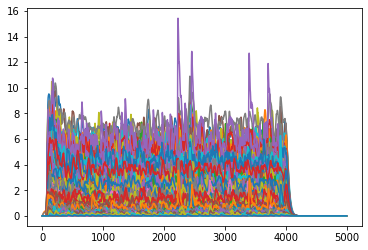

In [9]:
dt_step = 0.5
baseline_s = int(300 / dt_step)
baseline_e = int(400 / dt_step)
event_s = int(500 /dt_step)
cell_ids = dict()
mean_list = list()
for cell_id, vs in dv['p1'].items():
    cell_depolarisation = list()
    for s, v in vs.items():
        if max(v)  < -70:
            c = np.mean(v[baseline_s:baseline_e])
            d = v - c
            #plt.plot(d[event_s:])
        cell_depolarisation.append(d[event_s:])
    mean_depolarisation = np.mean(cell_depolarisation, axis=0)
    plt.plot(mean_depolarisation)
    cell_ids.update({cell_id: np.max(mean_depolarisation)})
    mean_list.append(mean_depolarisation)

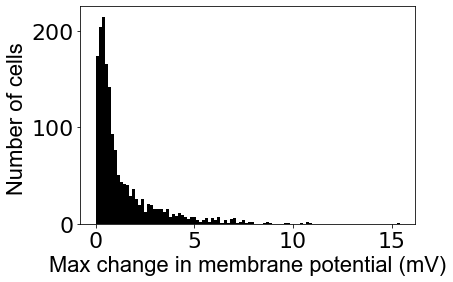

In [18]:
max_list = [np.max(m) for m in mean_list]
fig, ax = plt.subplots()
csfont = {"fontname": "Arial", 'fontsize': 22}
a = ax.hist(max_list, bins=100, color="black")
plt.ylabel("Number of cells ", **csfont)
plt.xlabel("Max change in membrane potential (mV)", **csfont)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.savefig(os.path.join("dendritic_voltage_change","histogram_average_membrane_potential_response.svg"))
plt.show()

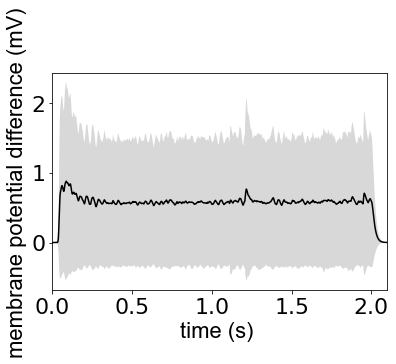

In [20]:
fig, ax = plt.subplots()
csfont = {"fontname": "Arial", 'fontsize': 22}
m = np.mean(mean_list,axis=0)
t = np.arange(len(m)) * 0.5e-3
std = np.std(mean_list,axis=0)
plt.plot(t, m, c= "black")
plt.fill_between(t, m-std, m+std ,alpha=0.3, facecolor="grey")
plt.ylabel("membrane potential difference (mV)", **csfont)
plt.xlim((0,2.1))
plt.xlabel("time (s) ", **csfont)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.savefig(os.path.join("dendritic_voltage_change","average_membrane_potential_response.svg"))
plt.show()

In [12]:
network_path = os.path.join(external,"pdc_network_2022-08-31","network-synapses.hdf5")
data = SnuddaLoad(network_file=network_path)

Loading 40000 neurons with 35040256 synapses and 2531 gap junctions


In [13]:
config = json.loads(data.data['config'])
center = np.array(config['PopulationUnits']['Striatum']['centres'][0])

In [14]:
neuron_types = data.get_neuron_types()
soma_positions = data.data["neuronPositions"]
remove_grids = True
step_size = 10
scale_position_x = 5.2e-3

In [15]:
tmp = dict()
max_distance = 0
for c, value in cell_ids.items():
    
    if not(np.isnan(value)):
    
        a = soma_positions[int(c)]

        b = center

        dist = np.linalg.norm(a-b) * 1e6

        tmp.update({int(c): {"distance":dist, "amplitude": value}})

        if dist > max_distance:
            max_distance = dist
        
max_distance  

557.7951017447533

In [16]:
response = {200:list(),300:list(),400:list()}
for c, data in tmp.items():
    
    if 200 <= data["distance"] <= 250:
        response[200].append(data["amplitude"])
        
    elif 250 <= data["distance"] <= 350:
        response[300].append(data["amplitude"])
        
    elif 350 <= data["distance"] <= 600:
        response[400].append(data["amplitude"])
        
        



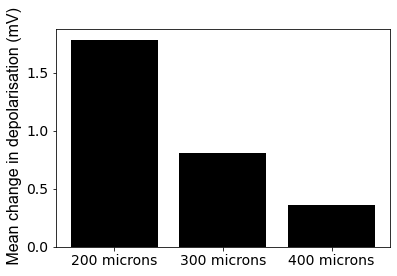

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
csfont = {"fontname": "Arial", 'fontsize': 16}
distances = ['200 microns', '300 microns', '400 microns']
students = [np.mean(v) for k, v in response.items()]
plt.bar(distances,students, color="black")
plt.ylabel(" Mean change in depolarisation (mV)", **csfont)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.savefig(os.path.join("dendritic_voltage_change","bar_average_membrane_potential_response_per_distance.svg"))
plt.show()